In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
from urllib.parse import quote
import datetime
import seaborn as sns
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
# import itertools
# import statsmodels.api as sm
# from pylab import rcParams

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = True

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

np.float_ = np.float64

# %matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Importing plotly failed. Interactive plots will not work.


Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [2]:
cur_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("current times:", cur_time)

current times: 2024-08-07 02:16:15


In [3]:
weekly_summary = pd.read_csv('./data/weekly_summary.csv')

In [4]:
weekly_summary = weekly_summary.set_index('date')

In [5]:
print('Series has {} missing values'.format(weekly_summary.isna().sum()))
date_missed = weekly_summary[weekly_summary.isna()].index

Series has total_case    0
temp          0
press         0
humidity      0
rain          0
dtype: int64 missing values


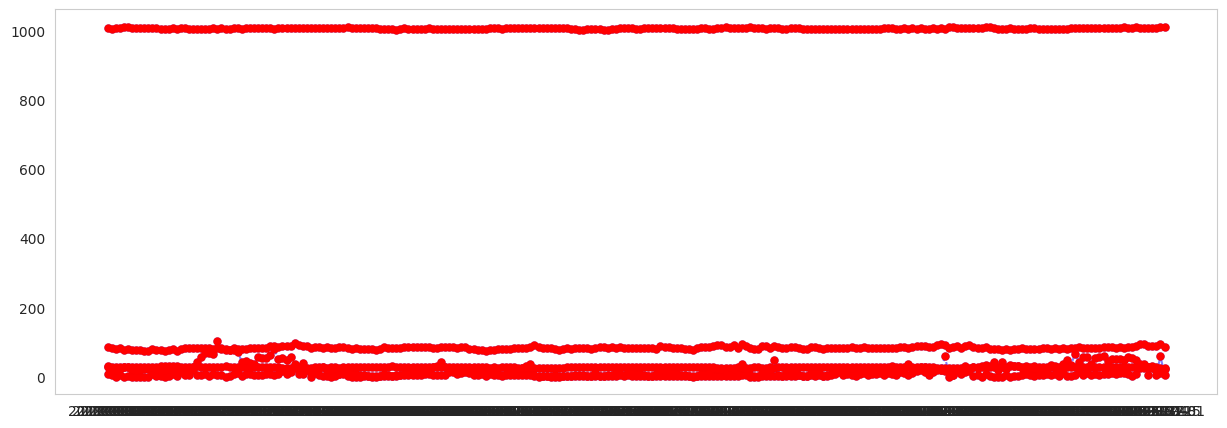

In [6]:
y_filled = weekly_summary.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(weekly_summary, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

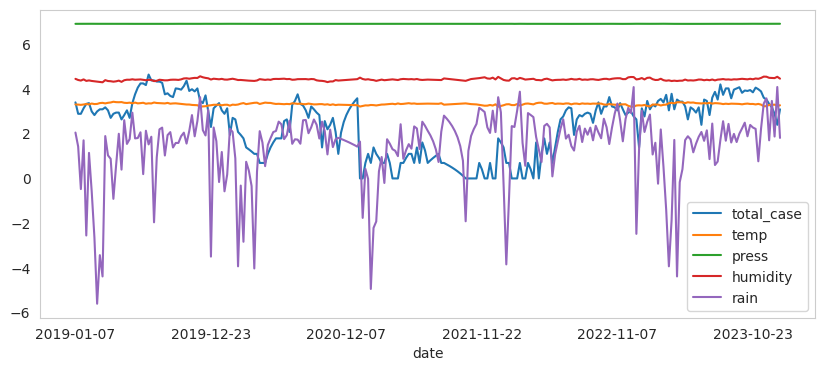

In [7]:
np.log(y_filled).plot(figsize=(10,4))

In [72]:
uscon = weekly_summary

In [73]:

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':uscon.index,'y':uscon.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,y
count,261.000000
mean,20.729885
std,19.818722
min,1.000000
25%,3.000000
50%,17.142857
75%,29.000000
max,104.000000


<Axes: xlabel='date'>

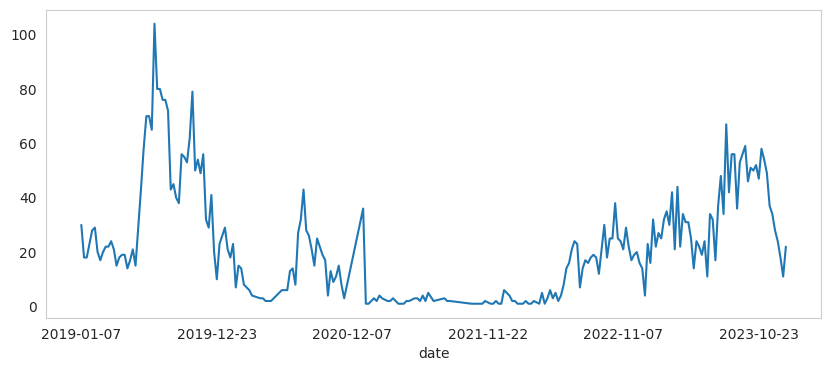

In [74]:
ts['y'].plot(figsize=(10,4))

In [75]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, 2019-01-07 to 2024-01-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  261 non-null    float64
 1   temp        261 non-null    float64
 2   press       261 non-null    float64
 3   humidity    261 non-null    float64
 4   rain        261 non-null    float64
dtypes: float64(5)
memory usage: 20.3+ KB


In [77]:
uscon = uscon.reset_index()

In [79]:
uscon.head()

,date,total_case,temp,press,humidity,rain
0,2019-01-07,30.0,27.282259,1005.820689,85.897126,7.777041
1,2019-01-14,18.0,27.177412,1005.009584,81.642037,4.164286
2,2019-01-21,18.0,26.849482,1007.035567,79.545775,0.621429
3,2019-01-28,23.0,27.270083,1006.782040,83.890311,5.496281
4,2019-02-04,28.0,27.903425,1008.452154,78.378565,0.078027


In [80]:
uscon['date'] = pd.to_datetime(uscon['date'])

In [81]:
newdf = uscon[uscon['date'].dt.year != 2021]

In [86]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2019-01-07 to 2024-01-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  209 non-null    float64
 1   temp        209 non-null    float64
 2   press       209 non-null    float64
 3   humidity    209 non-null    float64
 4   rain        209 non-null    float64
dtypes: float64(5)
memory usage: 9.8 KB


In [83]:
newdf = newdf['date'].set_index()

In [85]:
newdf.drop(['date'], axis=1, inplace=True)

In [23]:

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':newdf.index,'y':newdf.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,209,209.000000
mean,2021-07-05 20:53:58.277511936,25.232057
min,2019-01-07 00:00:00,1.000000
25%,2020-01-06 00:00:00,11.000000
50%,2022-01-03 00:00:00,21.000000
75%,2023-01-02 00:00:00,34.000000
max,2024-01-01 00:00:00,104.000000
std,NaN,19.572594


<Axes: xlabel='date'>

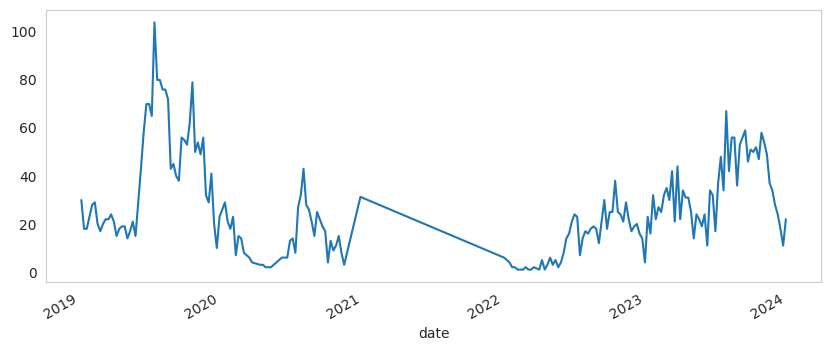

In [24]:
ts['y'].plot(figsize=(10,4))

In [32]:
print('Series has {} missing values'.format(newdf.isna().sum()))
date_missed = newdf[newdf.isna()].index

Series has total_case    0
temp          0
press         0
humidity      0
rain          0
dtype: int64 missing values


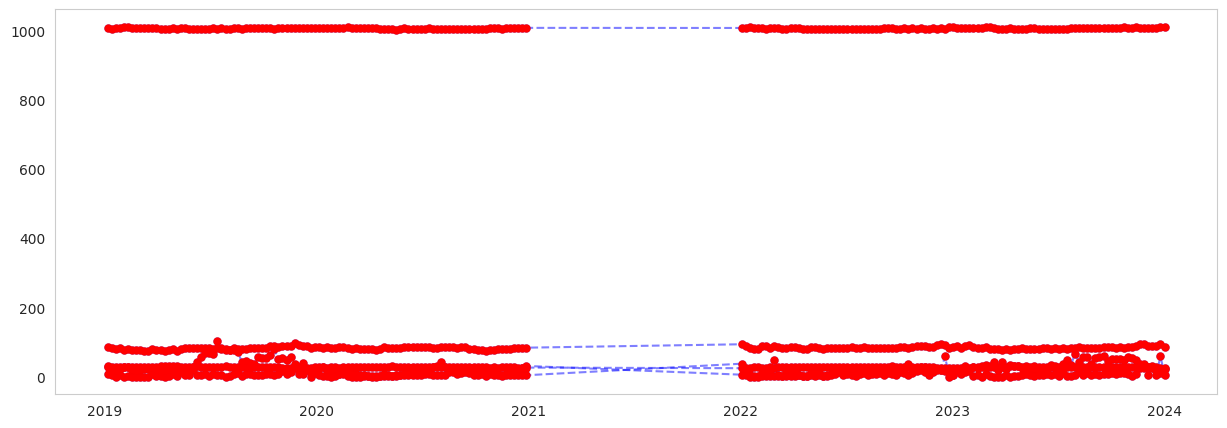

In [33]:
y_filled = newdf.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(newdf, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

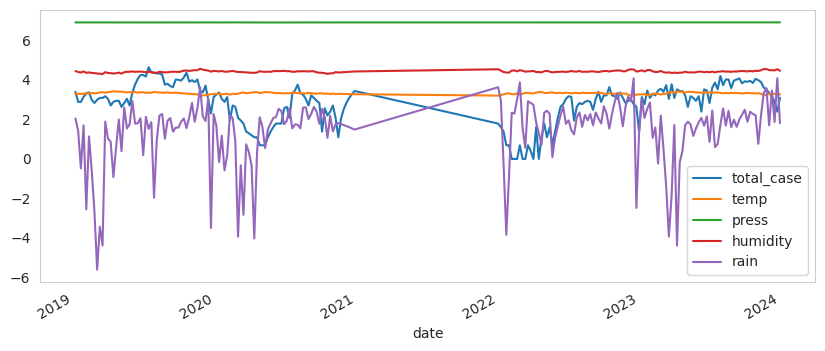

In [34]:
np.log(y_filled).plot(figsize=(10,4))

In [61]:
newdf2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2019-03-31 to 2024-03-31
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        262 non-null    datetime64[ns]
 1   total_case  262 non-null    float64       
 2   temp        262 non-null    float64       
 3   press       262 non-null    float64       
 4   humidity    262 non-null    float64       
 5   rain        262 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 14.3 KB


In [62]:
# newdf2.drop(['date'], axis=1, inplace=True)

In [60]:
newdf2 = newdf2.set_index(newdf2['date'])

In [55]:
# uscon['date'] = pd.to_datetime(uscon['date'])
# uscon = uscon.set_index('date') 
newdf2 = newdf2.resample('W').mean().interpolate(method='linear')
# weekly_summary = uscon.resample('D').sum()
newdf2.head()

,total_case,temp,press,humidity,rain
date,,,,,
2019-03-31,22.583333,27.936255,1006.970850,79.196617,2.383099
2019-04-07,22.918803,28.050752,1006.848519,79.258541,2.630258
2019-04-14,23.254274,28.165249,1006.726188,79.320465,2.877417
2019-04-21,23.589744,28.279746,1006.603858,79.382388,3.124576
2019-04-28,23.925214,28.394243,1006.481527,79.444312,3.371734


In [57]:
newdf2 = newdf2.reset_index()

In [ ]:
newdf2[newdf2['date'].dt.year == 2021]

In [71]:
newdf2.head()

,total_case,temp,press,humidity,rain
date,,,,,
2019-03-31,22.583333,27.936255,1006.970850,79.196617,2.383099
2019-04-07,22.918803,28.050752,1006.848519,79.258541,2.630258
2019-04-14,23.254274,28.165249,1006.726188,79.320465,2.877417
2019-04-21,23.589744,28.279746,1006.603858,79.382388,3.124576
2019-04-28,23.925214,28.394243,1006.481527,79.444312,3.371734


KeyError: "None of [DatetimeIndex(['2019-01-07', '2019-01-14', '2019-01-21', '2019-01-28',\n               '2019-02-04', '2019-02-11', '2019-02-18', '2019-02-25',\n               '2019-03-04', '2019-03-11',\n               ...\n               '2023-10-30', '2023-11-06', '2023-11-13', '2023-11-20',\n               '2023-11-27', '2023-12-04', '2023-12-11', '2023-12-18',\n               '2023-12-25', '2024-01-01'],\n              dtype='datetime64[ns]', name='date', length=209, freq=None)] are in the [index]"

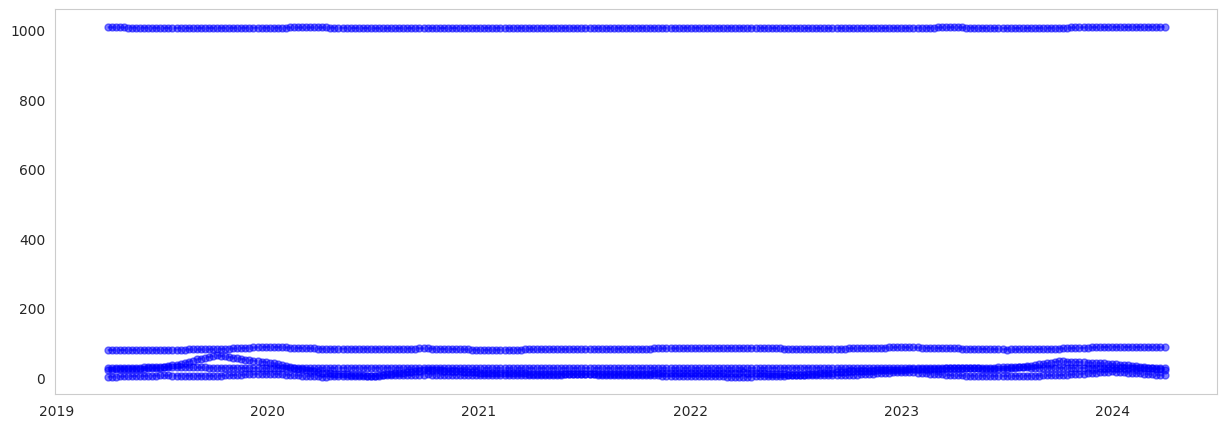

In [64]:
y_filled = newdf2.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(newdf2, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

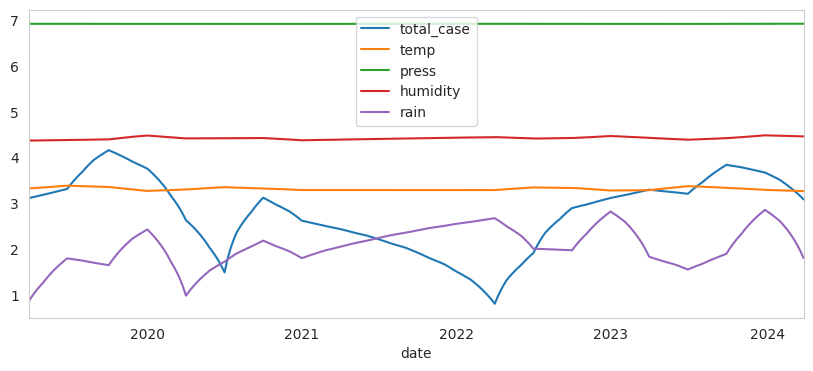

In [65]:
np.log(y_filled).plot(figsize=(10,4))

In [35]:
def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [36]:
cointegration_test(newdf)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
total_case > 95.06 > 69.82 => True
temp > 55.73 > 47.85 => True
press > 29.94 > 29.8 => True
humidity > 15.5 > 15.49 => True
rain > 6.24 > 3.84 => True


In [41]:
split_ratio = 0.7
train_size = int(len(newdf)*split_ratio)
Y_train, Y_test = newdf[:train_size], newdf[train_size:]

In [38]:
import itertools

In [39]:
def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [42]:
results = grid_search_VARMA(Y_train,3,3)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 